In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from xgboost import XGBClassifier
import time
import pandas as pd
import cv2
import numpy as np

In [26]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [27]:

train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')
train.isnull().any().sum()
test.isnull().any().sum()

0

In [28]:
train.shape

(60000, 785)

In [29]:
test.shape

(10000, 785)

In [30]:
df_train = train.copy()
df_test = test.copy()

In [31]:
X_train= df_train.drop(['label'],axis = 1)
X_label = df_train['label']
y_test = df_test.drop(['label'],axis = 1)
y_label = df_test['label']

X_train = X_train.astype('float32')
y_test = y_test.astype('float32')
X_train /= 255.0
y_test /=255.0

In [32]:
# X_train과 X_label을 하나의 데이터 프레임으로 합침
df_train = pd.concat([X_train, X_label], axis=1)

# 데이터 프레임을 섞음
df_train = df_train.sample(frac=1, random_state=42)

# 섞인 데이터 프레임에서 훈련 데이터와 레이블을 다시 분리
X_train = df_train.drop(['label'], axis=1)
X_label = df_train['label']

In [33]:
X_label = X_label.values # change to array for mAP

In [34]:
y_label = y_label.values # change to array for mAP

In [35]:
from skimage.feature import hog
def apply_hog(images):
    result = []
    for image in images:
        hog_features = hog(image, orientations=9, pixels_per_cell=(1, 1),
                        cells_per_block=(2, 2), block_norm='L2-Hys')
        result.append(hog_features)
    return result


In [36]:
print(X_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)


In [37]:
X_train = np.array(X_train)
X_train = X_train.reshape(-1, 28, 28)
y_test = np.array(y_test)
y_test = y_test.reshape(-1, 28, 28)

In [38]:
print(X_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [39]:
X_train_hog = apply_hog(X_train)
y_test_hog = apply_hog(y_test)
X_train_hog = np.array(X_train_hog)
y_test_hog = np.array(y_test_hog)


In [40]:
print("HOG 특성을 적용한 X_train의 형태: ", np.array(X_train_hog).shape)
print("HOG 특성을 적용한 y_test의 형태: ", np.array(y_test_hog).shape)

HOG 특성을 적용한 X_train의 형태:  (60000, 6084)
HOG 특성을 적용한 y_test의 형태:  (10000, 6084)


<ipython-input-41-542a7b0d6ea1>:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_features, hog_image = hog(image, orientations=8, pixels_per_cell=(2, 2),


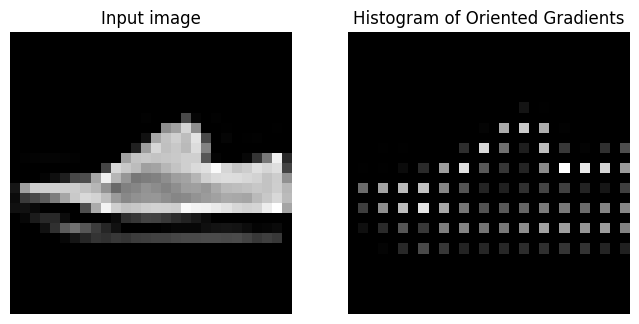

In [41]:
from skimage.io import imshow
from skimage import exposure
# 첫 번째 이미지의 HOG 특성 계산 및 시각화
image = X_train[0].reshape((28, 28))
hog_features, hog_image = hog(image, orientations=8, pixels_per_cell=(2, 2),
                              cells_per_block=(2, 2), visualize=True, multichannel=False)

# 원본 이미지와 HOG 특성 이미지를 출력
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [42]:
from sklearn.metrics import auc
from collections import Counter
def calculate_mAP(preds,label):
    ## mAP calculation
    AP = []
    num_class = 10
    predict_label_count_dict = Counter(preds)
    predict_label_count_dict = dict(sorted(predict_label_count_dict.items()))

    # For each class
    for c, freq in predict_label_count_dict.items() :
        TP = 0
        FN = 0

        temp_precision = []
        temp_recall = []

        for i in range(len(preds)):
            # Calculate TP and FN
            if label[i] == c and preds[i] == c :
                TP += 1
            elif label[i] != c and preds[i] == c :
                FN += 1

            # Calculate precision and recall
            if TP+FN != 0:
                temp_precision.append(TP/(TP+FN))
                temp_recall.append(TP/freq)

        # Save the AP value of each class to AP array
        AP.append(auc(temp_recall, temp_precision))

    # Calculate mAP
    mAP = sum(AP) / num_class

    return mAP


In [43]:
pca = PCA(n_components=400)
pca.fit(X_train_hog)
X_train_pca = pca.transform(X_train_hog)
y_test_pca = pca.transform(y_test_hog)

X_train_PCA1 = pd.DataFrame(X_train_pca)
X_test_PCA1 = pd.DataFrame(y_test_pca)

In [44]:
optimal_c = 8
svc = SVC(gamma='scale',kernel='rbf',C=optimal_c )
svc.fit(X_train_PCA1,X_label)

SVC(C=5)

In [45]:
svc_train = svc.predict(X_train_PCA1)
svc_pred = svc.predict(X_test_PCA1)

In [46]:
train_acc = metrics.accuracy_score(X_label,svc_train)
test_acc = metrics.accuracy_score(y_label, svc_pred)

print("Train Accuracy score: {}".format(train_acc))
print("Test Accuracy score: {}".format(test_acc))
print(metrics.classification_report(y_label, svc_pred))

Train Accuracy score: 0.9973666666666666
Test Accuracy score: 0.9202
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.90      0.87      0.88      1000
           3       0.91      0.93      0.92      1000
           4       0.86      0.90      0.88      1000
           5       0.98      0.96      0.97      1000
           6       0.78      0.77      0.77      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [47]:
map_train = calculate_mAP(svc_train,X_label)
map_test = calculate_mAP(svc_pred,y_label)

In [48]:
print("Train Map score: {}".format(map_train))
print("Test Map score: {}".format(map_test))

Train Map score: 0.9945491441671198
Test Map score: 0.8488310895952289
